In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import seaborn as sns

In [3]:
# Load data
def load_reports(directory_path):
    csv_files = glob.glob(os.path.join(directory_path, "*Report.csv"))
    reports = []
    for file in csv_files:
        reports.append(pd.read_csv(file, index_col=0, low_memory=False))
    return pd.concat(reports, ignore_index=True)


qmastor_rail_data_dump = pd.read_csv("./data/QMASTOR rail data dump.csv", low_memory=False, index_col=0)
reports = load_reports("data")

In [4]:
# Processing Dates and Time-stamps
def convert_to_datetime(date_string):
    if date_string == 'NaT':
        date_string = '2999-12-31 23:59:59'

    input_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(date_string, input_format)

# Preprocessing reports
def preprocess_tpt(df, drop_columns=['Act_Acc_No', 'RBCT_IngoMass', 'TFR Delay subtracted', 'Plan Note External', 'Act Note External', 'Cancellation Notes']):
    df = df.drop(drop_columns, axis=1)
    
    # Removing undesired columns
    datetime_cols = ['T1', 'SL', 'FL', 'T2', 'Date', 'BU Plan Date', 'Actual Volume Date']
    for col in datetime_cols:
        df[col] = df[col].apply(convert_to_datetime)

    # Removing rows without any definite status
    df = df[[not(x) for x in df['CX_Reason'].isna()]]

    return df

In [5]:
processed_reports = preprocess_tpt(reports)

# Selected features
processed_reports.columns

Index(['Date', 'Year', 'Month', 'Week_of_Year', 'Week_of_Month', 'BU_Name',
       'SalesGrouping', 'Flow_Name', 'Flow_Source', 'Flow_Destination',
       'SP_Name', 'NWB Export Account', 'NWB Exp Stockp', 'Act Export Account',
       'Act Exp Stockp', 'BU Plan Date', 'Actual Volume Date', 'Train Status',
       'T1', 'SL', 'FL', 'T2', 'Rail_ConsignmentNo', 'RBCT_ConsignmentNo',
       'Wagon_Type', 'CNWB_Volume', 'Act_Volume', 'Block_Load', 'CNWB_Wagons',
       'Act_Wagons', 'Source_TAT_SD', 'THT', 'TLT', 'CX_Group', 'CX_Reason',
       'Actual Notes', 'FirstOfEntry_ID'],
      dtype='object')

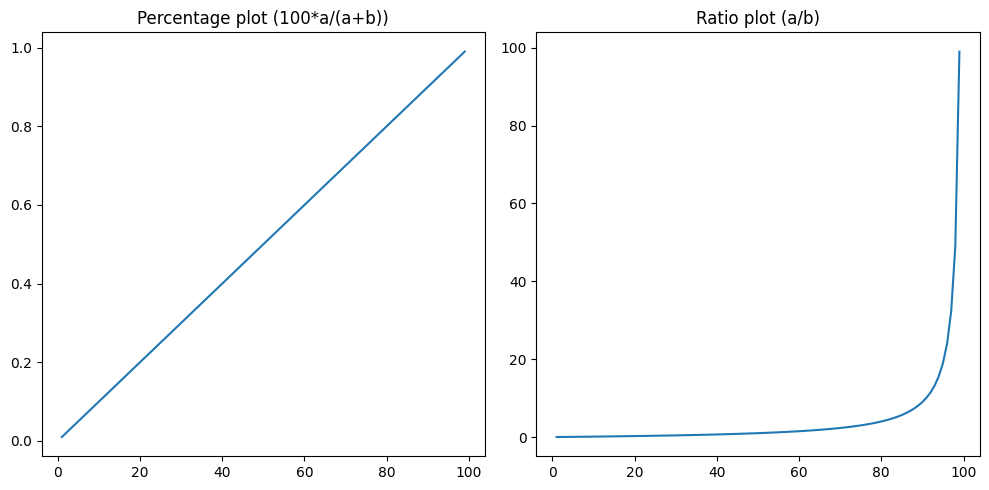

In [6]:
# Visualising nature of percentage contribution and ratio of two elements "a" and "b", where a+b=c

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(range(1,100), [x/100 for x in range(1,100)])
axs[0].set_title('Percentage plot (100*a/(a+b))')

axs[1].plot(range(1,100), [x/(100-x) for x in range(1,100)])
axs[1].set_title('Ratio plot (a/b)')
plt.tight_layout()
plt.show()

In [15]:
# Calculating ratio of cancelled trains over confirmed train 
# I preferred ratio over percentage as due to exaggerated nature of the graph
def cx_ratio(df, col):
    filtered_df = df[[col, 'CX_Reason']]
    filtered_df['Counter'] = [x!='No Cancellation' for x in filtered_df['CX_Reason']]
    group = filtered_df.groupby([col,'Counter']).size().unstack()
    group[group[True].isna()] = 1
    group[group[False].isna()] = 1
    group['rx_ratio'] = group[False]/group[True]
    
    return group

# Calculating standard deviation reasons of cancellation over specified feature
def std_calculation(df, col):
    filtered_df = df[[col, 'CX_Reason']]
    grouped = filtered_df.groupby([col, 'CX_Reason']).size().unstack()
    grouped['total'] = grouped.sum(axis=1)
    for col in grouped.columns:
        grouped[col] = 100*grouped[col]/(grouped['total']+1)
    
    grouped = grouped.T
    grouped['std'] = grouped.std(axis=1,skipna=True) / grouped.mean(axis=1, skipna=True)
    return grouped

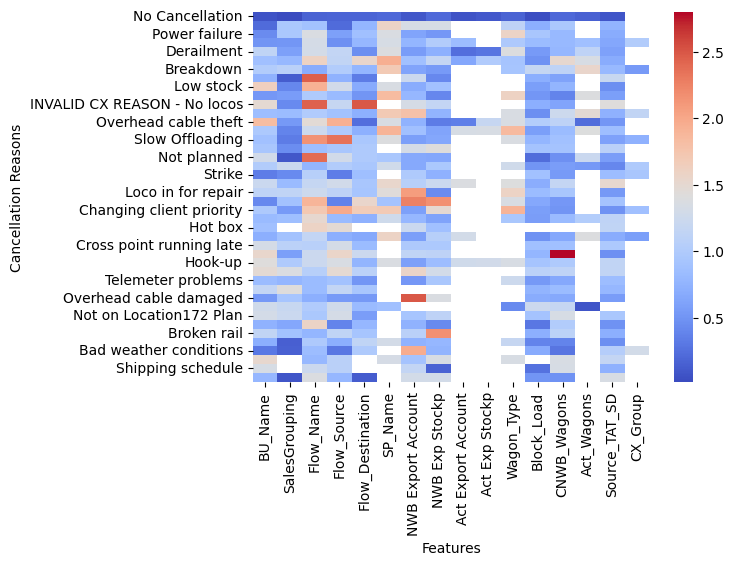

In [16]:
# Visualising normalised standard deviation of cancellation reasons corresponding to different features
'''
In the plotted heatmap, a consistent color in a row represents a consistent rate cancellation,
that might be because of the reason being more fundamental and common
'''
'''
Inconsistent color might be due to outliers or a change in the trend of the usage of the reason being used.
'''

col_list = ['BU_Name', 'SalesGrouping', 'Flow_Name', 'Flow_Source', 'Flow_Destination',
       'SP_Name', 'NWB Export Account', 'NWB Exp Stockp', 'Act Export Account',
       'Act Exp Stockp', 'Wagon_Type', 'Block_Load', 'CNWB_Wagons',
       'Act_Wagons', 'Source_TAT_SD', 'CX_Group']


cx_reasons_df = pd.DataFrame(columns = processed_reports['CX_Reason'].unique())
for col in col_list:
    df = std_calculation(processed_reports, col)
    row = df['std']
    index = col
    cx_reasons_df.loc[index] = row
cx_reasons_df = cx_reasons_df.T

sns.heatmap(cx_reasons_df, cmap='coolwarm')
plt.xlabel('Features')
plt.ylabel('Cancellation Reasons')
plt.show()

In [40]:
# Analysing relation between "Flow Name" and cancellation due to low stocks

flow_nm_cx = processed_reports[['Year', 'Week_of_Year', 'Flow_Name', 'Flow_Source', 'Flow_Destination', 'CX_Reason']]
flow_nm_cx.sample(4)

,Year,Week_of_Year,Flow_Name,Flow_Source,Flow_Destination,CX_Reason
33370,2020,10,Location80 to Location125 (Location40 MP LTA),Location80,Location125,No Cancellation
27121,2017,47,Location54 to Location96,Location54,Location171,No Cancellation
21248,2015,31,Location54 to Location156 Depot,Location54,Location156,No Cancellation
2373,2009,43,Location74 to Location160,Location74,Location176,No Cancellation


C:\Users\gaura\AppData\Local\Temp\ipykernel_9572\1457970135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_nm_cx['Counter'] = 1
C:\Users\gaura\AppData\Local\Temp\ipykernel_9572\1457970135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_nm_cx['Low stock'] = flow_nm_cx['CX_Reason']=='Low stock'


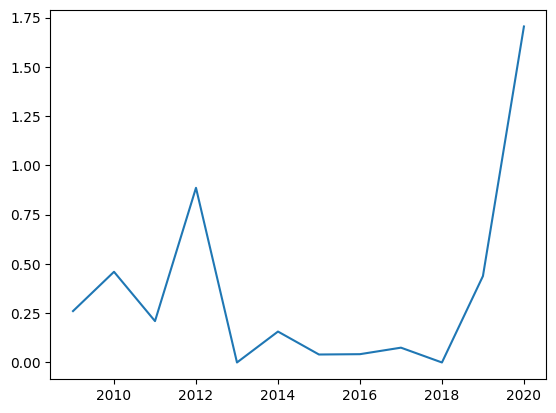

In [46]:
flow_nm_cx['Counter'] = 1
flow_nm_cx['Low stock'] = flow_nm_cx['CX_Reason']=='Low stock'
cx_cnt = flow_nm_cx.groupby('Year')[['Counter', 'Low stock']].sum()
cx_cnt['percentage'] = 100*cx_cnt['Low stock']/cx_cnt['Counter']

plt.plot(cx_cnt.index, cx_cnt.percentage)
plt.show()

In [52]:
# Checking distribution of percentage contribution of "low stock" amound different flows

name_cx_cnt = flow_nm_cx.groupby(['Flow_Name', 'Year']).sum(['Counter', 'Low stock'])
name_cx_cnt['percentage'] = 100*name_cx_cnt['Low stock']/name_cx_cnt['Counter']

In [ ]:
for flow_name, group_data in name_cx_cnt.groupby('Flow_Name'):
    plt.figure()  # Create a new plot for each 'Flow_Name'
    plt.plot(group_data['Year'], group_data['percentage'], marker='o', label='percentage')
    plt.title(f'Counter vs Year for Flow {flow_name}')
    plt.xlabel('Year')
    plt.ylabel('Counter')
    plt.legend()
    plt.grid(True)
    plt.show()